# Testing on oxford flowers 102 Dataset

**Importing the libraries and loading the dataset**

In [1]:
import torchvision.transforms as transforms
from torch.utils.data import Dataset
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
import os
import openai
import configparser
import torch
import clip
from torch.utils.data import Subset
import sys
sys.path.append('../')
from Classifier import Classifier
config = configparser.ConfigParser()
config.read('../config.ini')

api_key = config['openai']['api_key']
openai.api_key = api_key

dataset = ImageFolder(root='./flowers')
labels=dataset.classes

Label: columbine


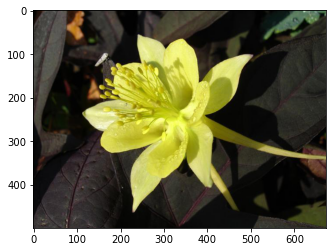

In [2]:
print(f"Label: {labels[dataset[2051][1]]}")
plt.imshow(dataset[2051][0])

**Creating a classifier and loading descriptors that were generated previously**

In [3]:
flowers=Classifier(labels)

In [4]:
flowers.load_classifier('oxfordflowers102.txt')

In [5]:
flowers.descriptors['columbine']

['has a long, slender stem',
 'has delicate, bell-shaped flowers',
 'has leaves that are arranged in a spiral',
 'has flowers that come in a variety of colors, including white, yellow, pink, and blue']

**Classifying with the descriptors**

In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load('ViT-B/32', device)
tokenized_text = torch.cat([clip.tokenize(label) for label in labels]).to(device)

In [7]:
from time import time
sum1=0
sum2=0
for i in range(0,len(dataset),100):
    if i==8100:
        subset=Subset(dataset,[j for j in range(i,len(dataset))])
        images=torch.stack([flowers.preprocess(image) for (image,label) in subset])
        lab=torch.Tensor([label for (image,label) in subset])
    else:
        subset=Subset(dataset,[j for j in range(i,i+100)])
        images=torch.stack([flowers.preprocess(image) for (image,label) in subset])
        lab=torch.Tensor([label for (image,label) in subset])
    print(f'Starting predictions: {i}')
    t=time()
    pred1=flowers.multi_classify(images,preprocessed=True)
    sum1+=torch.sum((pred1==lab)+0.)
    
    logits=model(images,tokenized_text)[0]
    pred2=torch.argmax(logits,dim=1)
    sum2+=torch.sum((pred2==lab)+0.)
    print(time()-t)
avg1=sum1/len(dataset)
avg2=sum2/len(dataset)

print(f'Accuracy of the custom algorithm: {avg1}')
print(f'Accuracy of the traditional zero shot prediction: {avg2}')

Starting predictions: 0
489.27217268943787
Starting predictions: 100
528.2093982696533
Starting predictions: 200
674.1836442947388
Starting predictions: 300
669.8709003925323
Starting predictions: 400
717.8182964324951
Starting predictions: 500
635.7409765720367
Starting predictions: 600
702.2801990509033
Starting predictions: 700
595.4344227313995
Starting predictions: 800
749.114146232605
Starting predictions: 900
574.9140019416809
Starting predictions: 1000
708.0035212039948
Starting predictions: 1100
647.1350002288818
Starting predictions: 1200
747.8267850875854
Starting predictions: 1300
525.5479681491852
Starting predictions: 1400
706.7117736339569
Starting predictions: 1500
561.0349974632263
Starting predictions: 1600
718.9558396339417
Starting predictions: 1700
687.5631425380707
Starting predictions: 1800
723.8998987674713
Starting predictions: 1900
674.3804402351379
Starting predictions: 2000
686.3493146896362
Starting predictions: 2100
722.634902715683
Starting predictions: 2

In [8]:
with open("flowers102_results.txt", "w") as f:
    f.write(f'Accuracy of the custom algorithm: {avg1}')
    f.write(f'Accuracy of the traditional zero shot prediction: {avg2}')